Доработайте программу из задания Поиск частых наборов, чтобы она также выполняла поиск ассоциативных правил. Список результирующих правил должен выдаваться в удобочитаемом виде (антецедент→консеквент) с указанием поддержки и достоверности каждого правила. Дополнительные параметры программы: порог достоверности, способ упорядочивания результирующего списка наборов (по убыванию значения поддержки или лексикографическое).

Проведите эксперименты на наборах из задания 1. В экспериментах Зафиксируйте значение пороговое значение поддержки (например, 10%), варьируйте пороговое значение достоверности (например, от 70% до 95% с шагом 5%).

Выполните визуализацию полученных результатов в виде следующих диаграмм:
 - сравнение быстродействия поиска правил на фиксированном наборе данных при изменяемом пороге достоверности;
 - общее количество найденных правил на фиксированном наборе данных при изменяемом пороге достоверности.

Подготовьте список правил, в которых антецедент и консеквент суммарно включают в себя не более семи объектов (разумное количество). Проанализируйте и изложите содержательный смысл полученного результата.

Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  
 - формулировка задания;
 - гиперссылка на каталог репозитория с исходными текстами, наборами данных и др. сопутствующими материалами;
 - рисунки с результатами визуализации;
 - пояснения, раскрывающие смысл полученных результатов.


In [81]:
import pandas as pd
import chardet
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import time
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

In [82]:
# Монтируем Google Диск
drive.mount('/content/drive')

# Путь к файлу на Google Диске
file_path = '/content/drive/MyDrive/collabFiles2/baskets.csv'

# Определяем кодировку
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())

# Читаем CSV с нужной кодировкой
df = pd.read_csv(file_path, encoding=result['encoding'])
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,креветки,миндаль,авокадо,овощная смесь,зеленый виноград,цельнозерновая мука,батат,творог,энергетический напиток,томатный сок,низкокалорийный йогурт,зеленый чай,мед,салат,минеральная вода,лосось,ягодный сок,замороженный смузи,шпинат,оливковое масло
0,гамбургер,фрикадельки,яйца,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,чатни,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,индейка,авокадо,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,минеральная вода,молоко,энергетический батончик,рис,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,низкокалорийный йогурт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,сливочное масло,низкокалорийный майонез,свежий хлеб,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7496,гамбургер,замороженные овощи,яйца,картофель-фри,журнал,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,курица,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,эскалоп,зеленый чай,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Код снизу реализует функцию find_frequent_itemsets_and_association_rules, которая выполняет два ключевых анализа: поиск частых наборов элементов и ассоциативных правил по заданным порогам поддержки и достоверности.

В начале данные, переданные в виде DataFrame, преобразуются в список списков (transactions). Это необходимо, поскольку алгоритмы mlxtend (в частности, TransactionEncoder) работают с таким форматом. Далее из каждой транзакции удаляются значения NaN, чтобы избежать некорректной обработки при анализе.

Затем данные преобразуются в разряженную булеву матрицу, где каждая строка соответствует транзакции, а каждый столбец — уникальному товару. Если товар есть в транзакции — в ячейке будет True, иначе — False. Это делается с помощью TransactionEncoder, а результат преобразуется в DataFrame.

После подготовки данных применяется алгоритм Apriori для поиска частых наборов элементов, которые встречаются не менее, чем в min_support доле транзакций. Найденные наборы сохраняются в frequent_itemsets.

Далее осуществляется поиск ассоциативных правил на основе найденных частых наборов. Для этого используется функция association_rules, которая находит все возможные правила вида A → B, у которых достоверность (confidence) превышает min_confidence. После этого антецеденты и консеквенты преобразуются из множеств в строки для более удобного восприятия. В результирующем DataFrame остаются только четыре столбца: антецедент, консеквент, поддержка и достоверность.

In [83]:
def find_frequent_itemsets_and_association_rules(data, min_support, min_confidence, sort_by='support'):

    transactions = data.values.tolist()

    # Удаление значений NaN из транзакций
    transactions = [[item for item in transaction if not pd.isnull(item)] for transaction in transactions]

    # Преобразование в разряженную матрицу
    te = TransactionEncoder()
    te_transform = te.fit(transactions).transform(transactions)
    transactions_matrix = pd.DataFrame(te_transform, columns=te.columns_)

    # Поиск частых наборов с помощью алгоритма Apriori
    frequent_itemsets = apriori(transactions_matrix, min_support=min_support, use_colnames=True)

    # Поиск ассоциативных правил
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    rules["antecedent"] = rules["antecedents"].apply(lambda x: ', '.join(list(x)))
    rules["consequent"] = rules["consequents"].apply(lambda x: ', '.join(list(x)))
    rules = rules[["antecedent", "consequent", "support", "confidence"]]

    # Сортировка результатов
    if sort_by == 'support':
        frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
        rules = rules.sort_values(by='support', ascending=False)
    elif sort_by == 'byItems':
        frequent_itemsets = frequent_itemsets.sort_values(by='itemsets')
        rules = rules.sort_values(by=['antecedent', 'consequent'])

    return frequent_itemsets, rules


In [78]:
min_support = 0.002
min_confidence_values = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for min_confidence in min_confidence_values:
    frequent_itemsets, rules = find_frequent_itemsets_and_association_rules(df, min_support, min_confidence)
    display(f'Порог достоверности: {min_confidence}')
    display(pd.DataFrame(frequent_itemsets))
    display(pd.DataFrame(rules))
    print (len(rules))

'Порог достоверности: 0.7'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
2691,0.002000,"(рис, макароны, яйца, минеральная вода)"
2713,0.002000,"(растительное масло, шоколад, яйца, молоко)"
2714,0.002000,"(замороженные овощи, шоколад, молоко, говяжий ..."
2715,0.002000,"(макароны, замороженные овощи, креветки, шокол..."


,antecedent,consequent,support,confidence
0,"грибной соус, эскалоп",макароны,0.004267,0.744186
9,"суп, замороженные овощи, молоко",минеральная вода,0.003067,0.766667
11,"макароны, яйца, растительное масло",минеральная вода,0.003067,0.718750
10,"шоколад, замороженные овощи, оливковое масло",минеральная вода,0.002800,0.700000
13,"молоко, яйца, оливковое масло",минеральная вода,0.002667,0.714286
2,"макароны, обезжиренное молоко",минеральная вода,0.002533,0.730769
6,"говяжий фарш, креветки, замороженные овощи",макароны,0.002533,0.791667
4,"макароны, блинчики, растительное масло",минеральная вода,0.002267,0.739130
5,"макароны, суп, блинчики",минеральная вода,0.002267,0.772727
8,"помидоры, замороженные овощи, оливковое масло",макароны,0.002133,0.842105


16


'Порог достоверности: 0.75'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
2691,0.002000,"(рис, макароны, яйца, минеральная вода)"
2713,0.002000,"(растительное масло, шоколад, яйца, молоко)"
2714,0.002000,"(замороженные овощи, шоколад, молоко, говяжий ..."
2715,0.002000,"(макароны, замороженные овощи, креветки, шокол..."


,antecedent,consequent,support,confidence
5,"суп, замороженные овощи, молоко",минеральная вода,0.003067,0.766667
2,"говяжий фарш, креветки, замороженные овощи",макароны,0.002533,0.791667
1,"макароны, суп, блинчики",минеральная вода,0.002267,0.772727
0,"рис, говяжий фарш, блинчики",минеральная вода,0.002133,0.842105
4,"помидоры, замороженные овощи, оливковое масло",макароны,0.002133,0.842105
6,"рис, помидоры, молоко",макароны,0.002133,0.800000
3,"индейка, замороженные овощи, молоко",минеральная вода,0.002000,0.750000
7,"говяжий фарш, шоколад, замороженные овощи, молоко",минеральная вода,0.002000,0.750000
8,"макароны, креветки, замороженные овощи, шоколад",минеральная вода,0.002000,0.882353


9


'Порог достоверности: 0.8'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
2691,0.002000,"(рис, макароны, яйца, минеральная вода)"
2713,0.002000,"(растительное масло, шоколад, яйца, молоко)"
2714,0.002000,"(замороженные овощи, шоколад, молоко, говяжий ..."
2715,0.002000,"(макароны, замороженные овощи, креветки, шокол..."


,antecedent,consequent,support,confidence
0,"рис, говяжий фарш, блинчики",минеральная вода,0.002133,0.842105
1,"помидоры, замороженные овощи, оливковое масло",макароны,0.002133,0.842105
2,"рис, помидоры, молоко",макароны,0.002133,0.800000
3,"макароны, креветки, замороженные овощи, шоколад",минеральная вода,0.002000,0.882353


4


'Порог достоверности: 0.85'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
2691,0.002000,"(рис, макароны, яйца, минеральная вода)"
2713,0.002000,"(растительное масло, шоколад, яйца, молоко)"
2714,0.002000,"(замороженные овощи, шоколад, молоко, говяжий ..."
2715,0.002000,"(макароны, замороженные овощи, креветки, шокол..."


,antecedent,consequent,support,confidence
0,"макароны, креветки, замороженные овощи, шоколад",минеральная вода,0.002,0.882353


1


'Порог достоверности: 0.9'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
2691,0.002000,"(рис, макароны, яйца, минеральная вода)"
2713,0.002000,"(растительное масло, шоколад, яйца, молоко)"
2714,0.002000,"(замороженные овощи, шоколад, молоко, говяжий ..."
2715,0.002000,"(макароны, замороженные овощи, креветки, шокол..."


,antecedent,consequent,support,confidence


0


'Порог достоверности: 0.95'

,support,itemsets
47,0.238267,(минеральная вода)
42,0.188000,(макароны)
110,0.179733,(яйца)
28,0.170933,(картофель-фри)
104,0.163867,(шоколад)
...,...,...
2691,0.002000,"(рис, макароны, яйца, минеральная вода)"
2713,0.002000,"(растительное масло, шоколад, яйца, молоко)"
2714,0.002000,"(замороженные овощи, шоколад, молоко, говяжий ..."
2715,0.002000,"(макароны, замороженные овощи, креветки, шокол..."


,antecedent,consequent,support,confidence


0


In [70]:
def plot_performance_vs_confidence(min_support, min_confidence_values):

    execution_times = []

    for min_confidence in min_confidence_values:
        start_time = time.time()
        _, rules = find_frequent_itemsets_and_association_rules(df, min_support, min_confidence)
        execution_time = time.time() - start_time
        execution_times.append(execution_time)


    plt.figure(figsize=(10, 6))
    plt.plot(min_confidence_values, execution_times, marker='o', color='y')
    plt.xlabel('Порог достоверности')
    plt.ylabel('Время выполнения')
    plt.title('Сравнение быстродействия поиска правил при изменении порога достоверности')
    plt.grid(True)
    plt.show()

def plot_rule_count_vs_confidence(min_support, min_confidence_values):

    rule_counts = []

    for min_confidence in min_confidence_values:
        frequent_itemsets, rules = find_frequent_itemsets_and_association_rules(df, min_support, min_confidence)
        rule_counts.append(len(rules))

    plt.figure(figsize=(10, 6))
    plt.plot(min_confidence_values, rule_counts, marker='o', color='g')
    plt.xlabel('Достоверность')
    plt.ylabel('Количество правил')
    plt.title('Общее количество найденных правил при изменении порога достоверности')
    plt.grid(True)
    plt.show()


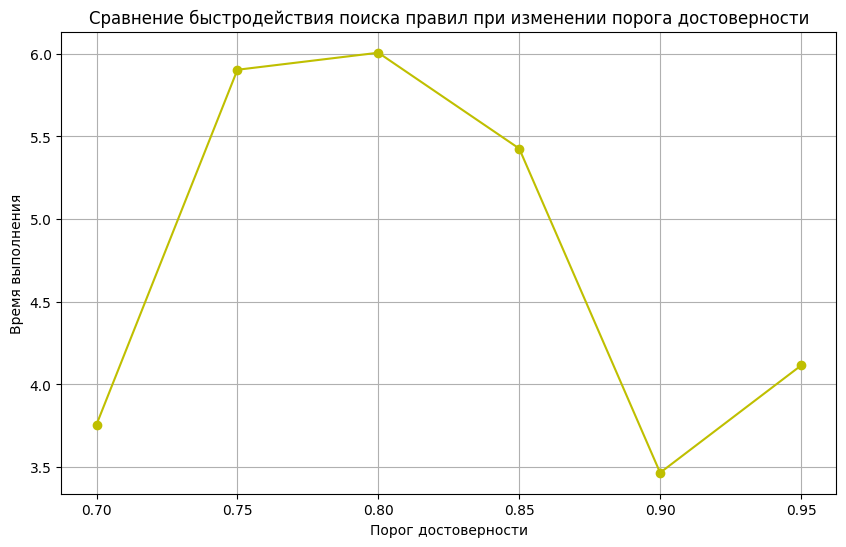

In [75]:

plot_performance_vs_confidence(min_support, min_confidence_values)

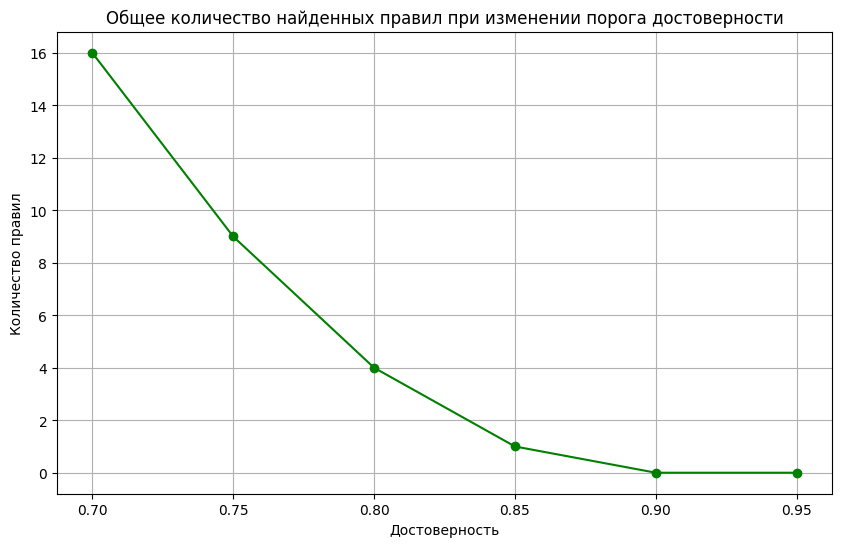

In [72]:
plot_rule_count_vs_confidence(min_support, min_confidence_values)

Правила, в которых антецедент и консеквент суммарно включают в себя не более семи объектов:

In [80]:
min_support = 0.002
min_confidence = 0.65

frequent_itemsets, rules = find_frequent_itemsets_and_association_rules(df, min_support, min_confidence)

# Отфильтруем правила, где количество элементов в антецеденте и консеквенте не превышает семь
result = rules[(rules['antecedent'].apply(lambda x: len(x.split(', '))) + rules['consequent'].apply(lambda x: len(x.split(', '))) <= 7)]

print("Всего:")
print(len(result))
result

Всего:
29


,antecedent,consequent,support,confidence
2,"грибной соус, эскалоп",макароны,0.004267,0.744186
13,"говяжий фарш, замороженные овощи, молоко",минеральная вода,0.003733,0.651163
19,"молоко, замороженные овощи, оливковое масло",минеральная вода,0.003333,0.694444
1,"хлопья, говяжий фарш",макароны,0.003067,0.676471
20,"суп, замороженные овощи, молоко",минеральная вода,0.003067,0.766667
15,"рис, макароны, говяжий фарш",минеральная вода,0.003067,0.657143
23,"макароны, яйца, растительное масло",минеральная вода,0.003067,0.718750
21,"шоколад, замороженные овощи, оливковое масло",минеральная вода,0.002800,0.700000
17,"рис, макароны, замороженные овощи",минеральная вода,0.002667,0.666667
26,"молоко, яйца, оливковое масло",минеральная вода,0.002667,0.714286
